## Imports

In [27]:
from transformers import AutoProcessor, TFBlipForQuestionAnswering, TFCLIPModel
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from constants import *
import utils
import os

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


## OK-VQA

In [3]:
dataset = load_dataset("Multimodal-Fatima/OK-VQA_train", cache_dir=SCRATCH_DIR+'/data')
train_set = dataset['train'].select(range(8000))
val_set = dataset['train'].select(range(8000, 9000))

Found cached dataset parquet (/scratch/vpaturu/temp/data/Multimodal-Fatima___parquet/Multimodal-Fatima--OK-VQA_train-c49be14e3379d8e4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
sample_data = train_set[0]
# 4739

## Models

In [5]:
blip_model_name = "Salesforce/blip-vqa-capfilt-large"
clip_model_name = "openai/clip-vit-base-patch32"

In [6]:
blip_large_model = TFBlipForQuestionAnswering.from_pretrained(blip_model_name, cache_dir=SCRATCH_DIR+'/models')
blip_large_model.trainable = False
blip_trained_model = TFBlipForQuestionAnswering.from_pretrained(blip_model_name, cache_dir=SCRATCH_DIR+'/trained_models')
blip_trained_model.trainable = True
blip_large_processor = AutoProcessor.from_pretrained(blip_model_name , cache_dir=SCRATCH_DIR+'/processors')


2023-12-11 20:14:11.626394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20159 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6
2023-12-11 20:14:11.634731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 26413 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:a1:00.0, compute capability: 8.6
2023-12-11 20:14:13.185263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
All model checkpoint layers were used when initializing TFBlipForQuestionAnswering.

All the layers of TFBlipForQuestionAnswering were initialized from the model checkpoint at Salesforce/blip-vqa-capfilt-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBlipForQuestionAnswering for predictions without further training.
Al

In [7]:
clip_model = TFCLIPModel.from_pretrained(clip_model_name, cache_dir=SCRATCH_DIR+'/models')
clip_processor = AutoProcessor.from_pretrained(clip_model_name, cache_dir=SCRATCH_DIR+'/processors')

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


## Context

In [8]:
# inputs = blip_large_processor(images=image, text=question, return_tensors="tf")
# labels = blip_large_processor(text=context_data, return_tensors="tf", padding=True, truncation=True).input_ids



## Training

In [9]:
# load faiss index from ./data/index.faiss
import faiss

index = faiss.read_index('./data/faiss_index.index')
sentences_df = pd.read_csv('./data/sentences.csv')

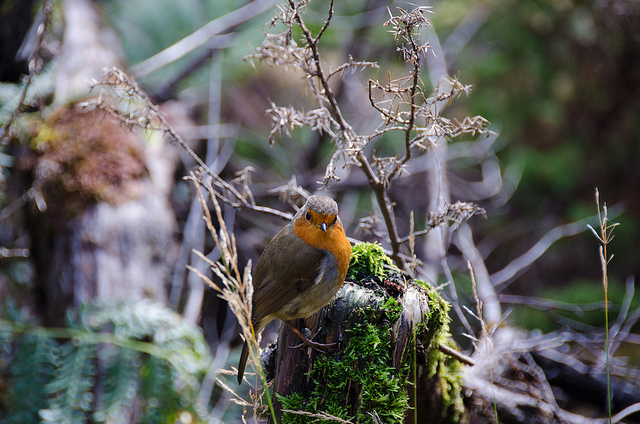

In [36]:
random_sample = train_set[random.randint(0, len(train_set))]
random_sample['image']

In [37]:
cont = utils.get_context(random_sample)
print(random_sample['question'])
for c in cont:
  print(c)

What type of bird is shown in the picture?
Bocket skiied in the 2014 Winter Paralympics in Sochi, Russia, where she won four gold medals.
Most birds can fly, and if they do, then the ability is inherited, not learnt. They fly by pushing through the air with their wings. The curved surfaces of the wings cause air currents (wind) which lift the bird. Flapping keeps the air current moving to create lift and also moves the bird forward.
Abrahamic religions are also practised. There is a Kaifeng Jewish community living in China. Also, Islam has been historically popular, introduced since the Tang Dynasty. The Hui people and Uyghur people are Muslims.
Farlow J.O. and Brett-Surman M.K. (eds) 1997. The Complete Dinosaur. Indiana University Press. 
Data until the end of December 1998.
He finished his law studies at the University of Ghent in 1885.  He then spent a few months in Paris, France. His first play, Princess Maleine, was well received in August 1890.
Several bird species make and use t

In [14]:
# def train_model(sample):
#     image = tf.convert_to_tensor(tf.image.resize(sample['image'], (224, 224))) / 255.0
#     question = sample['question']
#     answer = sample['answers'][0]
#     context = get_context(sample)

#     # create a prompt with context and question and use it to train the model
#     prompt = "Context: " + ''.join(context) + " Question: " + question + " Answer:"

#     inputs = blip_large_processor(images=image, text=prompt, return_tensors="tf", padding=True, truncation=True)
#     # inputs['input_ids'] = tf.concat([inputs['input_ids'], context], axis=1)
#     # inputs['attention_mask'] = tf.concat([inputs['attention_mask'], tf.ones(context.shape, dtype=tf.int32)], axis=1)
#     labels = blip_large_processor(text=answer, return_tensors="tf").input_ids
#     inputs["labels"] = labels

#     outputs = blip_trained_model(**inputs)
#     loss = outputs.loss
    
#     return loss.numpy()


In [15]:
def build_inputs(dataset, sample_size):
  images = []
  queries = []
  answers = []
  for i in range(sample_size):
    sample = dataset[i]
    image = utils.process_image(sample['image'])
    question = sample['question']
    # TODO: check with all answers
    answer = sample['answers'][0]
    context = utils.get_context(sample)

    # create a prompt with context and question and use it to train the model
    prompt = "Context: " + ''.join(context) + " Question: " + question + " Answer:"

    images.append(image)
    queries.append(prompt)
    answers.append(answer)
    print("Processed sample: ", i + 1, "/", sample_size, end="\r") 
  return images, queries, answers

In [ ]:
if not os.path.exists('./data/train.csv'):
  train_images, train_queries, train_answers = build_inputs(train_set, len(train_set)
  val_images, val_queries, val_answers = build_inputs(val_set, len(val_set))
  train_df = pd.DataFrame({'image': train_images, 'query': train_queries, 'answer': train_answers})
  val_df = pd.DataFrame({'image': val_images, 'query': val_queries, 'answer': val_answers})
  train_df.to_csv('./data/train.csv', index=False)
  val_df.to_csv('./data/val.csv', index=False)
else:
  train_df = pd.read_csv('./data/train.csv')
  val_df = pd.read_csv('./data/val.csv')
  train_images = train_df['image'].values.tolist()
  train_queries = train_df['query'].values.tolist()
  train_answers = train_df['answer'].values.tolist()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

blip_trained_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', 'bleu'])
inputs = blip_large_processor(images=train_images, text=train_queries, return_tensors="tf", padding=True, truncation=True)
labels = blip_large_processor(text=train_answers, return_tensors="tf", padding=True, truncation=True).input_ids
inputs["labels"] = labels

outputs = blip_trained_model(**inputs, return_dict=True, training=True)
print(outputs)

In [18]:
# save the model
blip_trained_model.save_pretrained(SCRATCH_DIR+'/trained_models')

## Inference

In [19]:
def inference(model, sample):
    image = sample['image']
    question = sample['question']
    context = utils.get_context(sample)
    # context = context.reshape(1, len(context))
    prompt = "Context: " + ''.join(context) + " Question: " + question + " Answer:"
    inputs = blip_large_processor(image, prompt, return_tensors="tf", padding=True, truncation=True)
    # inputs['input_ids'] = tf.concat([context, inputs['input_ids']], axis=1)
    # inputs['attention_mask'] = tf.concat([tf.ones(context.shape, dtype=tf.int32), inputs['attention_mask']], axis=1)
    outputs = model.generate(**inputs, max_new_tokens=20)
    res = blip_large_processor.decode(outputs[0], skip_special_tokens=True)
    return res

## Testing

In [20]:
def run_inference(model, i):
  sample_data = val_set[i]
  question = sample_data['question']
  res = inference(model, sample_data)
  answer = sample_data['answers'][0]

  print(i, ' | ', question, ': ', res, ' | ', answer)
  print("")

In [21]:
# get randomly 5 indices from val_set
codes = random.sample(range(len(val_set)), 5)

### Before training

In [31]:
for i in codes:
  run_inference(blip_large_model, i)

514  |  Why is that dog tired? :  yes  |  running

11  |  Who would want this? :  my best guess is yes  |  child

216  |  What event does this food signify? :  yes  |  baptism

406  |  What sort of material is gathered from this animal? :  yes  |  wool

385  |  How much does it cost for parking two hours? :  yes  |  $2



### After training

In [23]:
for i in codes:
  run_inference(blip_trained_model, i)

514  |  Why is that dog tired? :  yes  |  running

11  |  Who would want this? :  my best guess is yes  |  child

216  |  What event does this food signify? :  yes  |  baptism

406  |  What sort of material is gathered from this animal? :  yes  |  wool

385  |  How much does it cost for parking two hours? :  yes  |  $2



The results before the training are actually very different. I created a new model to see the difference, but maybe because I was using the same processor, It's returning the same results. But anyway, the results are different but not good after the training. So, we decided to move to BLIP 2 model.

In [24]:
# import random
# for i in random.sample(range(9010), 10):
#   run_inference(i)

## Example

In [25]:
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

# # training
# text = "How many cats are in the picture?"
# label = "2"
# inputs = blip_large_processor(images=image, text=text, return_tensors="tf")
# labels = blip_large_processor(text=label, return_tensors="tf").input_ids

# inputs["labels"] = labels
# outputs = blip_large_model(**inputs)
# loss = outputs.loss
# print(loss)
# # inference
# text = "How many cats are in the picture?"
# inputs = blip_large_processor(images=image, text=text, return_tensors="tf")
# outputs = blip_large_model.generate(**inputs)
# print(blip_large_processor.decode(outputs[0], skip_special_tokens=True))

In [26]:
# blip_large_model.train_on_batch